In [1]:
import os
import numpy as np
import pickle
import pandas as pd
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from PIL import Image
from sklearn.utils import shuffle

2023-09-10 09:19:40.786395: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
classNames = {
    'bench': 0,
    'deadlift': 1,
    'squat': 2
}

In [3]:
classNames['squat']

2

In [5]:
resized_images = []
labels = []
width = 128
height = 128
classes = 3
target_size = (width, height)
data_folder = "data"

for folder in os.listdir(data_folder):
    curr_path = os.path.join(data_folder, folder)
    for file in os.listdir(curr_path):
        curr_file = os.path.join(curr_path, file)
        image = Image.open(curr_file)
        image = image.resize(target_size, Image.LANCZOS)
        image_array = np.array(image)
        if len(image_array.shape) > 2 and image_array.shape[2] == 3:
            resized_images.append(image_array)
            labels.append(np.array(classNames[folder]))
            continue
        os.remove(curr_file)

In [6]:
features = np.array(resized_images)
labels = np.array(labels)

In [7]:
print(len(features))
print(len(labels))

399
399


In [8]:
features.shape

(399, 128, 128, 3)

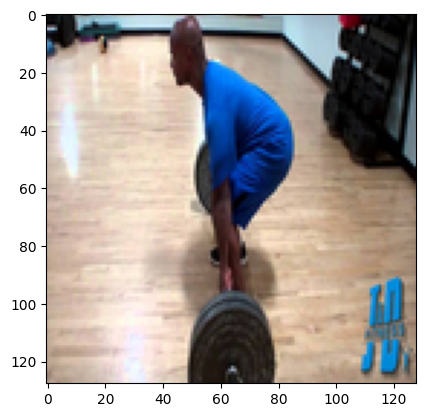

In [9]:
plt.imshow(features[2])

In [10]:
trainX, testX, trainY, testY = train_test_split(features, labels, test_size=0.2)

In [11]:
print(len(trainX))
print(len(trainY))
print(len(testX))
print(len(testY))

319
319
80
80


In [12]:
validX = testX
validY = testY

In [13]:
trainX, trainY = shuffle(trainX, trainY)

In [14]:
trainX = trainX.astype("float") / 255.0
validX = validX.astype("float") / 255.0
testX = testX.astype("float") / 255.0

In [15]:
trainX[0]

array([[[1.        , 1.        , 1.        ],
        [0.9254902 , 0.96078431, 0.95294118],
        [0.97647059, 0.98823529, 0.98823529],
        ...,
        [0.61960784, 0.65882353, 0.6745098 ],
        [0.37647059, 0.38823529, 0.43921569],
        [0.05490196, 0.05882353, 0.0745098 ]],

       [[1.        , 1.        , 1.        ],
        [0.9254902 , 0.95686275, 0.95294118],
        [0.96078431, 0.98039216, 0.97647059],
        ...,
        [0.62352941, 0.65882353, 0.67058824],
        [0.32941176, 0.33333333, 0.37647059],
        [0.0627451 , 0.07058824, 0.08627451]],

       [[1.        , 1.        , 1.        ],
        [0.94117647, 0.96862745, 0.96078431],
        [0.95686275, 0.97647059, 0.97254902],
        ...,
        [0.64313725, 0.66666667, 0.67843137],
        [0.27058824, 0.2745098 , 0.31372549],
        [0.07843137, 0.08627451, 0.10196078]],

       ...,

       [[0.10980392, 0.11372549, 0.1254902 ],
        [0.09803922, 0.10196078, 0.10980392],
        [0.09411765, 0

In [16]:
lb = LabelBinarizer()

In [17]:
trainY = lb.fit_transform(trainY)
validY = lb.fit_transform(validY)

In [18]:
validY[0]

array([0, 1, 0])

In [19]:
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD

In [20]:
shape = (width, height, 3)

In [21]:
model = Sequential()

In [22]:
model.add(Conv2D(128, (3, 3), padding="same", input_shape=(shape)))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(256, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Conv2D(256, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dense(classes))
model.add(Activation("softmax"))

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 128)     3584      
                                                                 
 activation (Activation)     (None, 128, 128, 128)     0         
                                                                 
 batch_normalization (Batch  (None, 128, 128, 128)     512       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 128)     147584    
                                                                 
 activation_1 (Activation)   (None, 128, 128, 128)     0         
                                                                 
 batch_normalization_1 (Bat  (None, 128, 128, 128)     512       
 chNormalization)                                       

In [24]:
aug = ImageDataGenerator(rotation_range=0.18, zoom_range=0.15, width_shift_range=0.2, height_shift_range=0.2, horizontal_flip=True)

In [25]:
learning_rate = 0.001
epochs = 100
batch_size = 64

In [26]:
opt = SGD(learning_rate=learning_rate, momentum=0.9)
model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])

In [27]:
print("Start training")
H = model.fit(aug.flow(trainX, trainY, batch_size=batch_size), validation_data=(validX, validY), steps_per_epoch=5, epochs=epochs, verbose=1)

Start training
Epoch 1/100
5/5 [==============================] - 84s 17s/step - loss: 2.2360 - accuracy: 0.3699 - val_loss: 1.0917 - val_accuracy: 0.3375
Epoch 2/100
5/5 [==============================] - 70s 14s/step - loss: 1.6049 - accuracy: 0.4734 - val_loss: 1.0718 - val_accuracy: 0.3375
Epoch 3/100
5/5 [==============================] - 76s 15s/step - loss: 1.1440 - accuracy: 0.5517 - val_loss: 1.1369 - val_accuracy: 0.3375
Epoch 4/100
5/5 [==============================] - 68s 14s/step - loss: 1.0090 - accuracy: 0.5643 - val_loss: 1.1716 - val_accuracy: 0.3375
Epoch 5/100
5/5 [==============================] - 79s 16s/step - loss: 0.9135 - accuracy: 0.5768 - val_loss: 1.2861 - val_accuracy: 0.3375
Epoch 6/100
5/5 [==============================] - 69s 13s/step - loss: 0.8269 - accuracy: 0.6270 - val_loss: 1.3918 - val_accuracy: 0.3375
Epoch 7/100
5/5 [==============================] - 65s 13s/step - loss: 0.8015 - accuracy: 0.6646 - val_loss: 1.4001 - val_accuracy: 0.3375
Epoch

In [28]:
model.save('train.keras')

In [29]:
saved_model = tf.keras.models.load_model('train.keras')

1/1 [==============================] - 0s 450ms/step
0


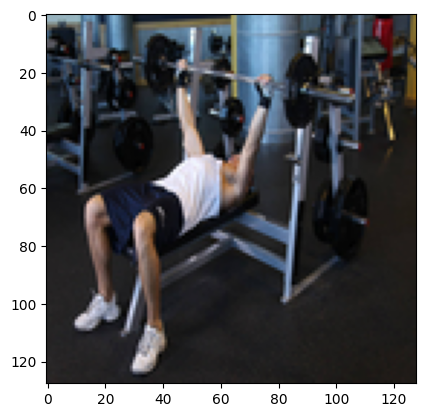

In [30]:
item = 10
result = saved_model.predict(testX[item:item + 1])
final = np.argmax(result)
print(final)
plt.imshow(testX[item])